In [1]:
import os
import copy

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.manifold import TSNE

In [2]:
import phate

In [3]:
os.chdir('..')
import manifold_methods
import plotting
import mappings
import data_loader

In [4]:
# Load HGDP
exp_path = '/lustre06/project/6065672/shared/DietNet/1KGB_POP24/HGDP_sub/'
fname = 'gnomad.genomes.v3.1.2.hgdp_tgp.PASSfiltered.newIDs.onlySNPs.noDuplicatePos.noMiss5perc.match1000G_GSAs_dietnet.hdf5'
metadata_file = 'labels.tsv'
unrelated_sampleid_1000G_path = '/lustre06/project/6065672/grenier2/DietNet/Generalisation/datasets_112023/HGDP_1KGP/1000G_unrelated_samples_set_2504.txt'
data_path = os.path.join(exp_path, fname)
metadata_path = os.path.join(exp_path, metadata_file)

inputs, class_labels, sample, snp_names, class_label_names, metadata_labels = data_loader.load_data_HDGP(data_path, metadata_path, unrelated_sampleid_1000G_path)

Removed 701 related individuals


In [5]:
#np.save('inputs_hgdp', inputs)
#metadata_labels.to_csv('metadata_labels_hgdp')
#pd.DataFrame(sample).to_csv('samples')

In [6]:
def make_palette_label_order_HGDP(metadata_labels):
    # SAS -> CSA + add MID, OCE
    pop_palette_hgdp_coarse = copy.deepcopy(mappings.pop_pallette_1000G_coarse)
    pop_palette_hgdp_coarse['CSA'] = mappings.pop_pallette_1000G_coarse['SAS']
    pop_palette_hgdp_coarse.pop('SAS')

    pop_palette_hgdp_coarse['MID'] = 'grey'
    pop_palette_hgdp_coarse['OCE'] = 'yellow'

    label_order_hgdp_coarse = copy.deepcopy(mappings.label_order_1000G_coarse)
    label_order_hgdp_coarse.remove('SAS')
    label_order_hgdp_coarse += ['CSA', 'MID', 'OCE']

    # Keep original 24/26 populations (with colors), and add new ones. New pops colored using superpop
    label_order_hgdp_fine = []
    for super_pop in np.unique(metadata_labels['Superpopulation']):
        for pop in np.unique(metadata_labels['Population'][metadata_labels['Superpopulation']==super_pop]):
            label_order_hgdp_fine.append(pop)

    # create tmp object to hold the original 26 populations
    mapping_26 = copy.deepcopy(mappings.pop_pallette_1000G_fine)
    mapping_26['GBR'] = mapping_26['CEUGBR']
    mapping_26['CEU'] = mapping_26['CEUGBR']
    mapping_26['STU'] = mapping_26['STUITU']
    mapping_26['ITU'] = mapping_26['STUITU']

    pop_palette_hgdp_fine = {}

    for super_pop in np.unique(metadata_labels['Superpopulation']):
        for pop in np.unique(metadata_labels['Population'][metadata_labels['Superpopulation']==super_pop]):
            if pop not in mapping_26.keys():
                # just use superpop color for now
                pop_palette_hgdp_fine[pop] = pop_palette_hgdp_coarse[super_pop]
            else:
                pop_palette_hgdp_fine[pop] = mapping_26[pop]

    return pop_palette_hgdp_coarse, pop_palette_hgdp_fine, label_order_hgdp_coarse, label_order_hgdp_fine

In [7]:
pop_palette_hgdp_coarse, pop_palette_hgdp_fine, label_order_hgdp_coarse, label_order_hgdp_fine = make_palette_label_order_HGDP(metadata_labels)

In [8]:
# Remove problematic populations
label_order_hgdp_coarse_nomiddle = copy.copy(label_order_hgdp_coarse)
label_order_hgdp_fine_nomiddle = copy.copy(label_order_hgdp_fine)

pop_to_exclude = ['BiakaPygmy', 
                    'ITU', 
                    'Kalash', 
                    'Karitiana', 
                    'Lahu', 
                    'MbutiPygmy', 
                    'Melanesian',
                    'Papuan',
                    'Pima',
                    'San',
                    'Surui',
                    'Yakut',
                    'Sardinian']

to_exclude_idx = ~metadata_labels['Population'].isin(pop_to_exclude)

label_order_hgdp_coarse_nomiddle.remove('OCE')

for x in pop_to_exclude:
    label_order_hgdp_fine_nomiddle.remove(x)

## Make PCA, PHATE, t-SNE

In [9]:
pca_obj = sklearn.decomposition.PCA(n_components=100, random_state=42)
pca_input = pca_obj.fit_transform(inputs[to_exclude_idx])

In [10]:
# initial phate embedding
phate_operator = phate.PHATE(random_state=42, knn=5, t=5, n_pca=None)
phate_operator.fit(pca_input)
phate_emb = phate_operator.transform()

Running PHATE on 3154 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.57 seconds.
  Calculating affinities...
  Calculated affinities in 0.05 seconds.
Calculated graph and diffusion operator in 0.62 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.16 seconds.
  Calculating KMeans...
  Calculated KMeans in 3.22 seconds.
Calculated landmark operator in 4.01 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.84 seconds.
Calculating metric MDS...
Calculated metric MDS in 3.68 seconds.


In [11]:
# t-SNE embedding
tsne_obj = TSNE(perplexity=30.0, early_exaggeration=4.0, learning_rate=1000)
tsne_emb = tsne_obj.fit_transform(pca_input)

## Visualizations

In [12]:
metadata_labels_nomiddle = metadata_labels[to_exclude_idx]

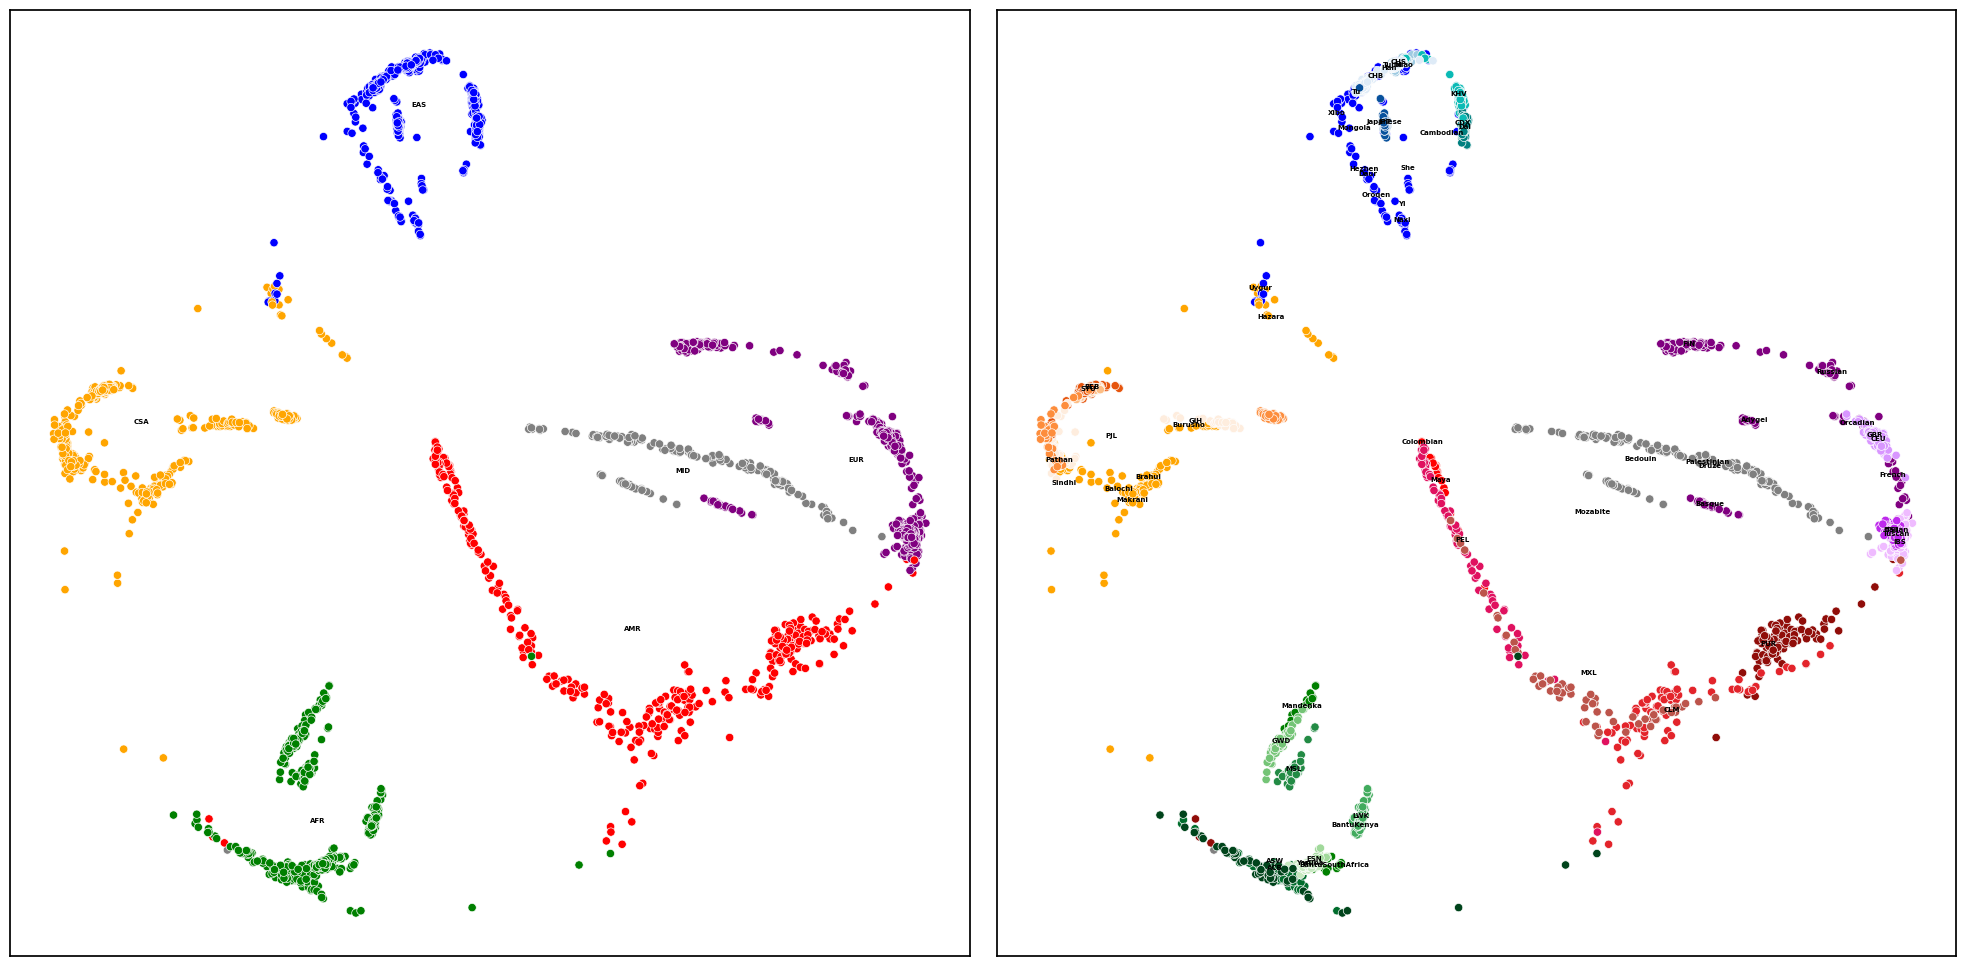

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(20,10))

plotting.plot_embeddings(phate_emb, 
                         metadata_labels_nomiddle['Superpopulation'].values, 
                         None,
                         pop_palette_hgdp_coarse,
                         label_order_hgdp_coarse_nomiddle,
                         True,
                         ax[0])
plotting.plot_embeddings(phate_emb, 
                         metadata_labels_nomiddle['Population'].values, 
                         None,
                         pop_palette_hgdp_fine,
                         label_order_hgdp_fine_nomiddle,
                         True,
                         ax[1])
plt.tight_layout()

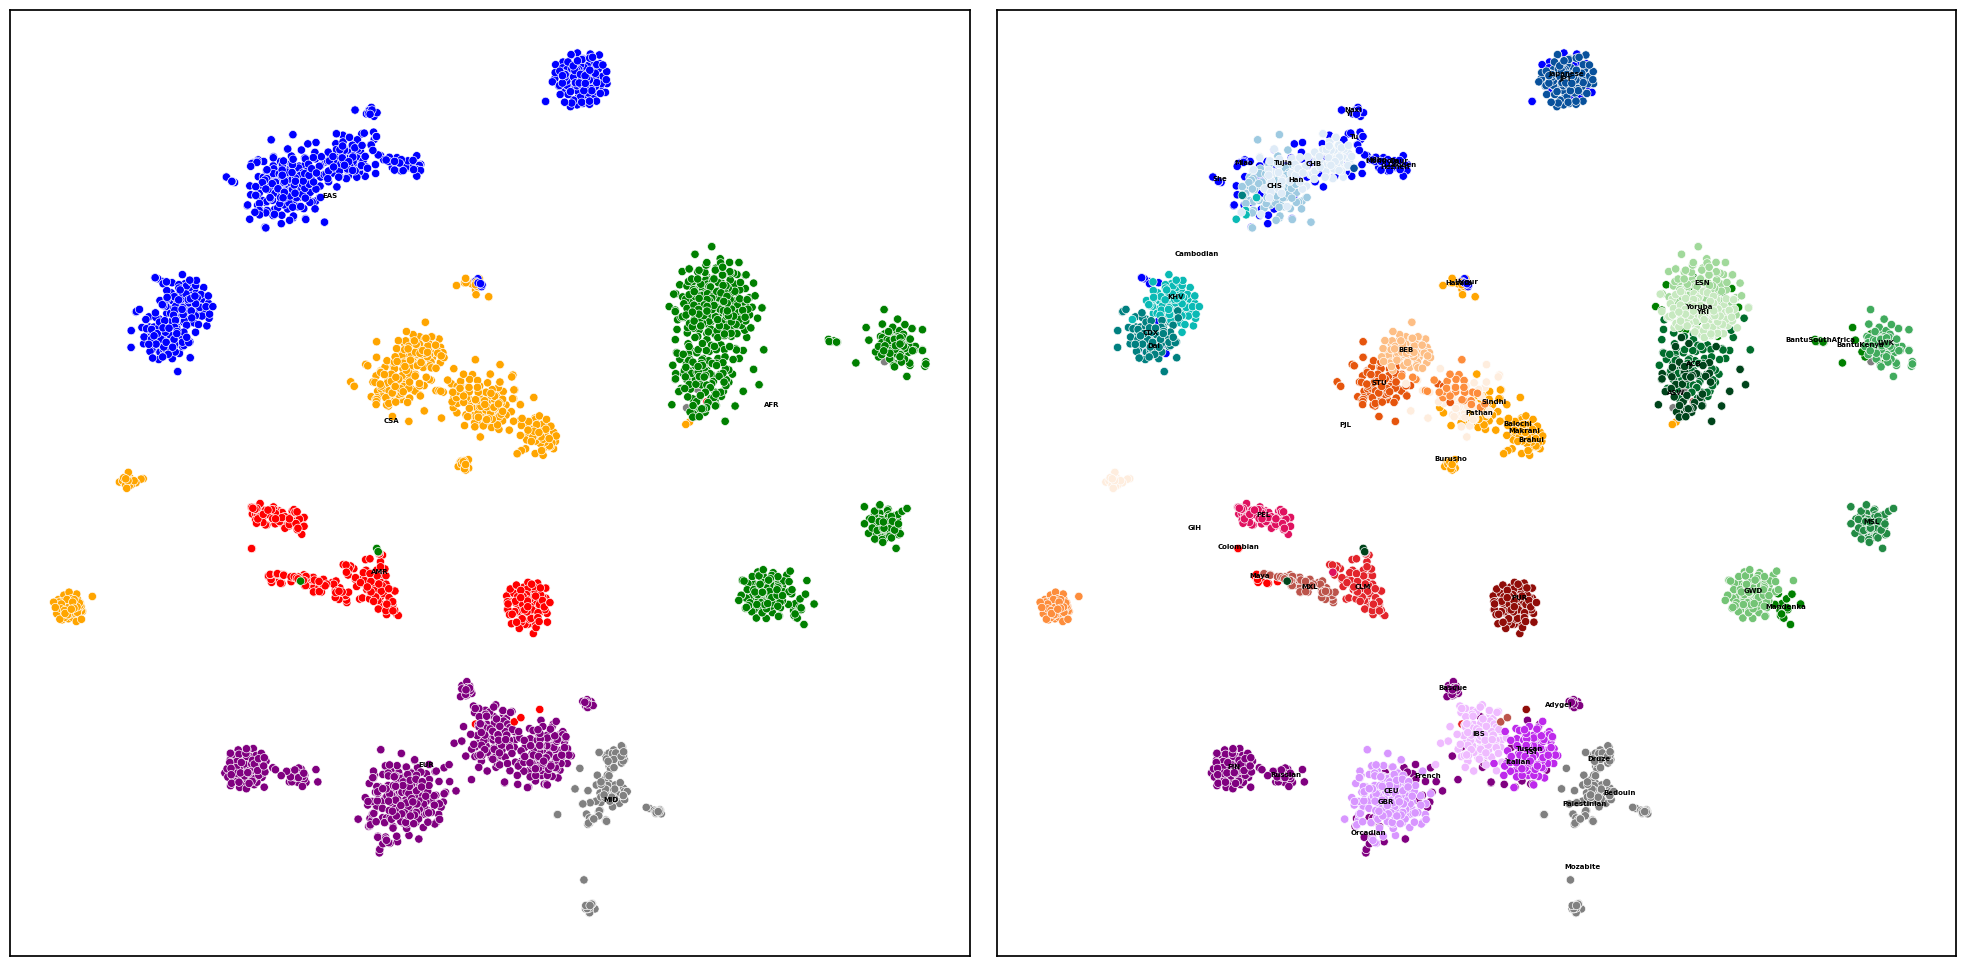

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(20,10))

plotting.plot_embeddings(tsne_emb, 
                         metadata_labels_nomiddle['Superpopulation'].values, 
                         None,
                         pop_palette_hgdp_coarse,
                         label_order_hgdp_coarse_nomiddle,
                         True,
                         ax[0])
plotting.plot_embeddings(tsne_emb, 
                         metadata_labels_nomiddle['Population'].values, 
                         None,
                         pop_palette_hgdp_fine,
                         label_order_hgdp_fine_nomiddle,
                         True,
                         ax[1])
plt.tight_layout()

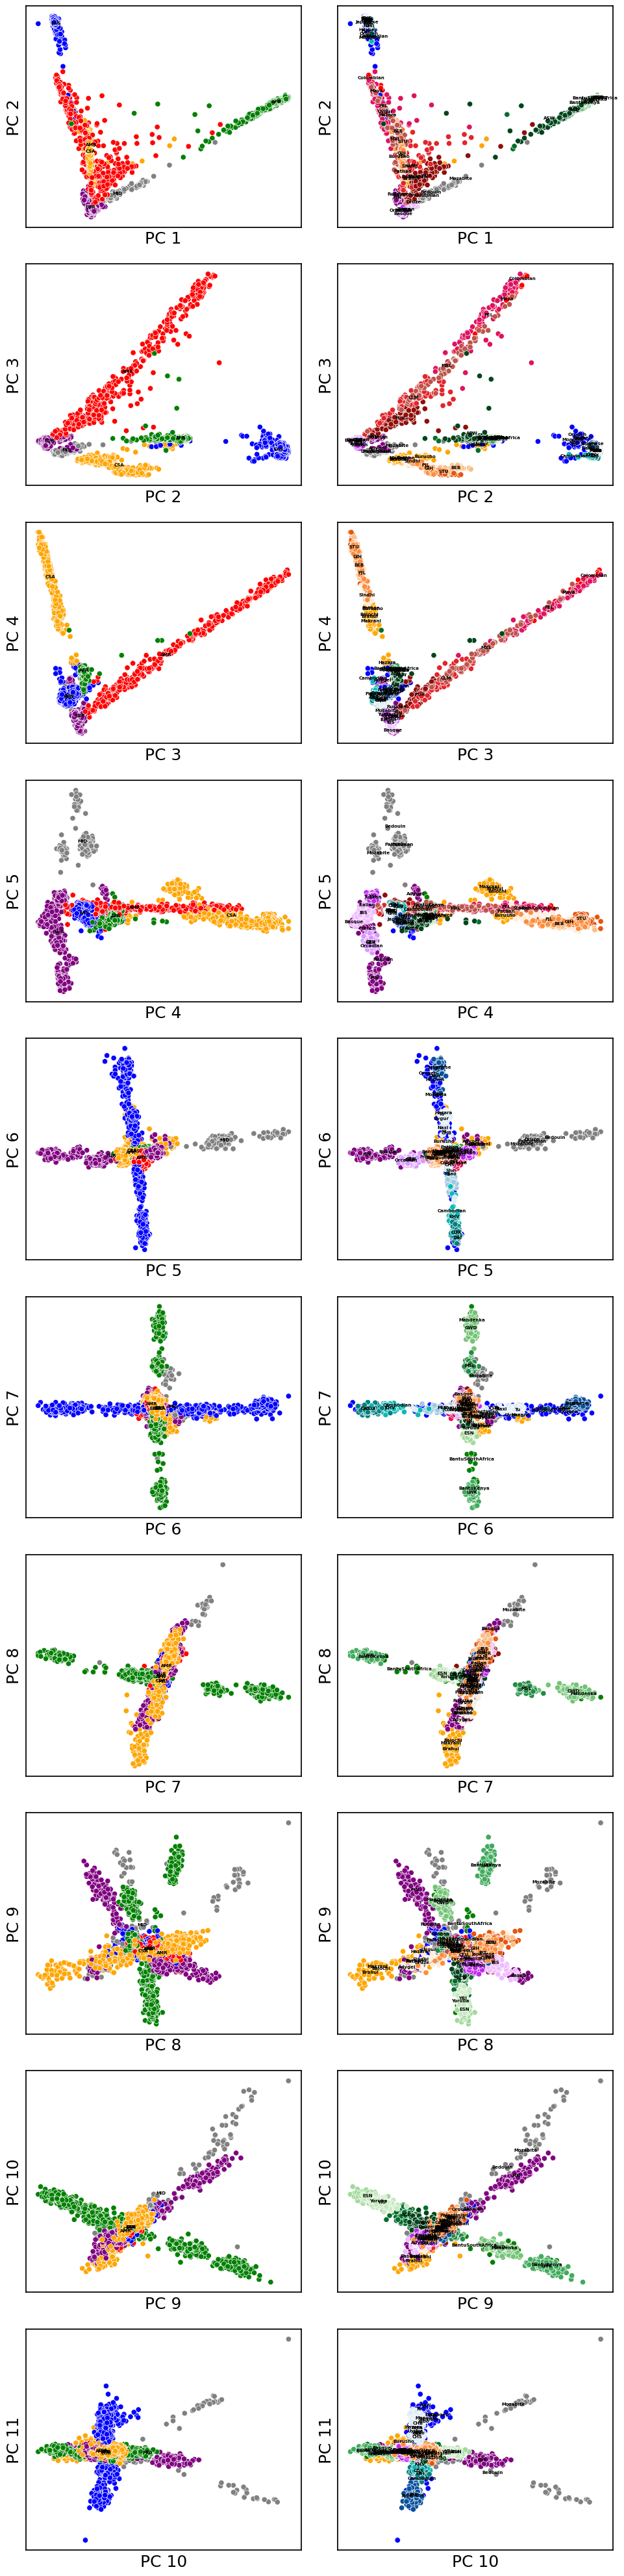

In [15]:
fig, ax = plt.subplots(nrows=10, ncols=2, figsize=(10,40))
for comp in range(10):
    # initial 2D phate embedding
    plotting.plot_embeddings(pca_input[:,comp:(comp+2)], 
                             metadata_labels_nomiddle['Superpopulation'].values, 
                             None,
                             pop_palette_hgdp_coarse,
                             label_order_hgdp_coarse_nomiddle,
                             True,
                             ax[comp, 0])
    plotting.plot_embeddings(pca_input[:,comp:(comp+2)], 
                             metadata_labels_nomiddle['Population'].values, 
                             None,
                             pop_palette_hgdp_fine,
                             label_order_hgdp_fine_nomiddle,
                             True,
                             ax[comp, 1])

    #ax[comp, 0].get_legend().remove()
    #ax[comp, 1].get_legend().remove()
    ax[comp, 0].set_xlabel('PC {}'.format(comp+1))
    ax[comp, 0].set_ylabel('PC {}'.format(comp+2))
    ax[comp, 1].set_xlabel('PC {}'.format(comp+1))
    ax[comp, 1].set_ylabel('PC {}'.format(comp+2))
plt.tight_layout()
#fig.savefig('figures/PCA_1000G+HGDP')

In [16]:
# Lets remove the AdMixed Pops
label_order_hgdp_coarse_nomiddle_noadmix = copy.copy(label_order_hgdp_coarse)
label_order_hgdp_fine_nomiddle_noadmix = copy.copy(label_order_hgdp_fine)

pop_to_exclude = np.unique(metadata_labels[metadata_labels['Superpopulation'] == 'AMR']['Population']).tolist()
pop_to_exclude += ['BiakaPygmy', 
                    'ITU', 
                    'Kalash', 
                    'Karitiana', 
                    'Lahu', 
                    'MbutiPygmy', 
                    'Melanesian',
                    'Papuan',
                    'Pima',
                    'San',
                    'Surui',
                    'Yakut',
                    'Sardinian']

# remove duplicates
pop_to_exclude = np.unique(pop_to_exclude).tolist()

to_exclude_idx = ~metadata_labels['Population'].isin(pop_to_exclude)

label_order_hgdp_coarse_nomiddle_noadmix.remove('AMR')
label_order_hgdp_coarse_nomiddle_noadmix.remove('OCE')

for x in pop_to_exclude:
    label_order_hgdp_fine_nomiddle_noadmix.remove(x)

In [17]:
pca_obj = sklearn.decomposition.PCA(n_components=100, random_state=42)
pca_input = pca_obj.fit_transform(inputs[to_exclude_idx])

In [18]:
# initial phate embedding
phate_operator = phate.PHATE(random_state=42, knn=5, t=5, n_pca=None)
phate_operator.fit(pca_input)
phate_emb = phate_operator.transform()

Running PHATE on 2779 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.47 seconds.
  Calculating affinities...
  Calculated affinities in 0.04 seconds.
Calculated graph and diffusion operator in 0.52 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.15 seconds.
  Calculating KMeans...
  Calculated KMeans in 1.33 seconds.
Calculated landmark operator in 2.06 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.73 seconds.
Calculating metric MDS...
Calculated metric MDS in 3.45 seconds.


In [19]:
# t-SNE embedding
tsne_obj = TSNE(perplexity=30.0, early_exaggeration=4.0, learning_rate=1000)
tsne_emb = tsne_obj.fit_transform(pca_input)

In [20]:
metadata_labels_nomiddle_noadmix = metadata_labels[to_exclude_idx]

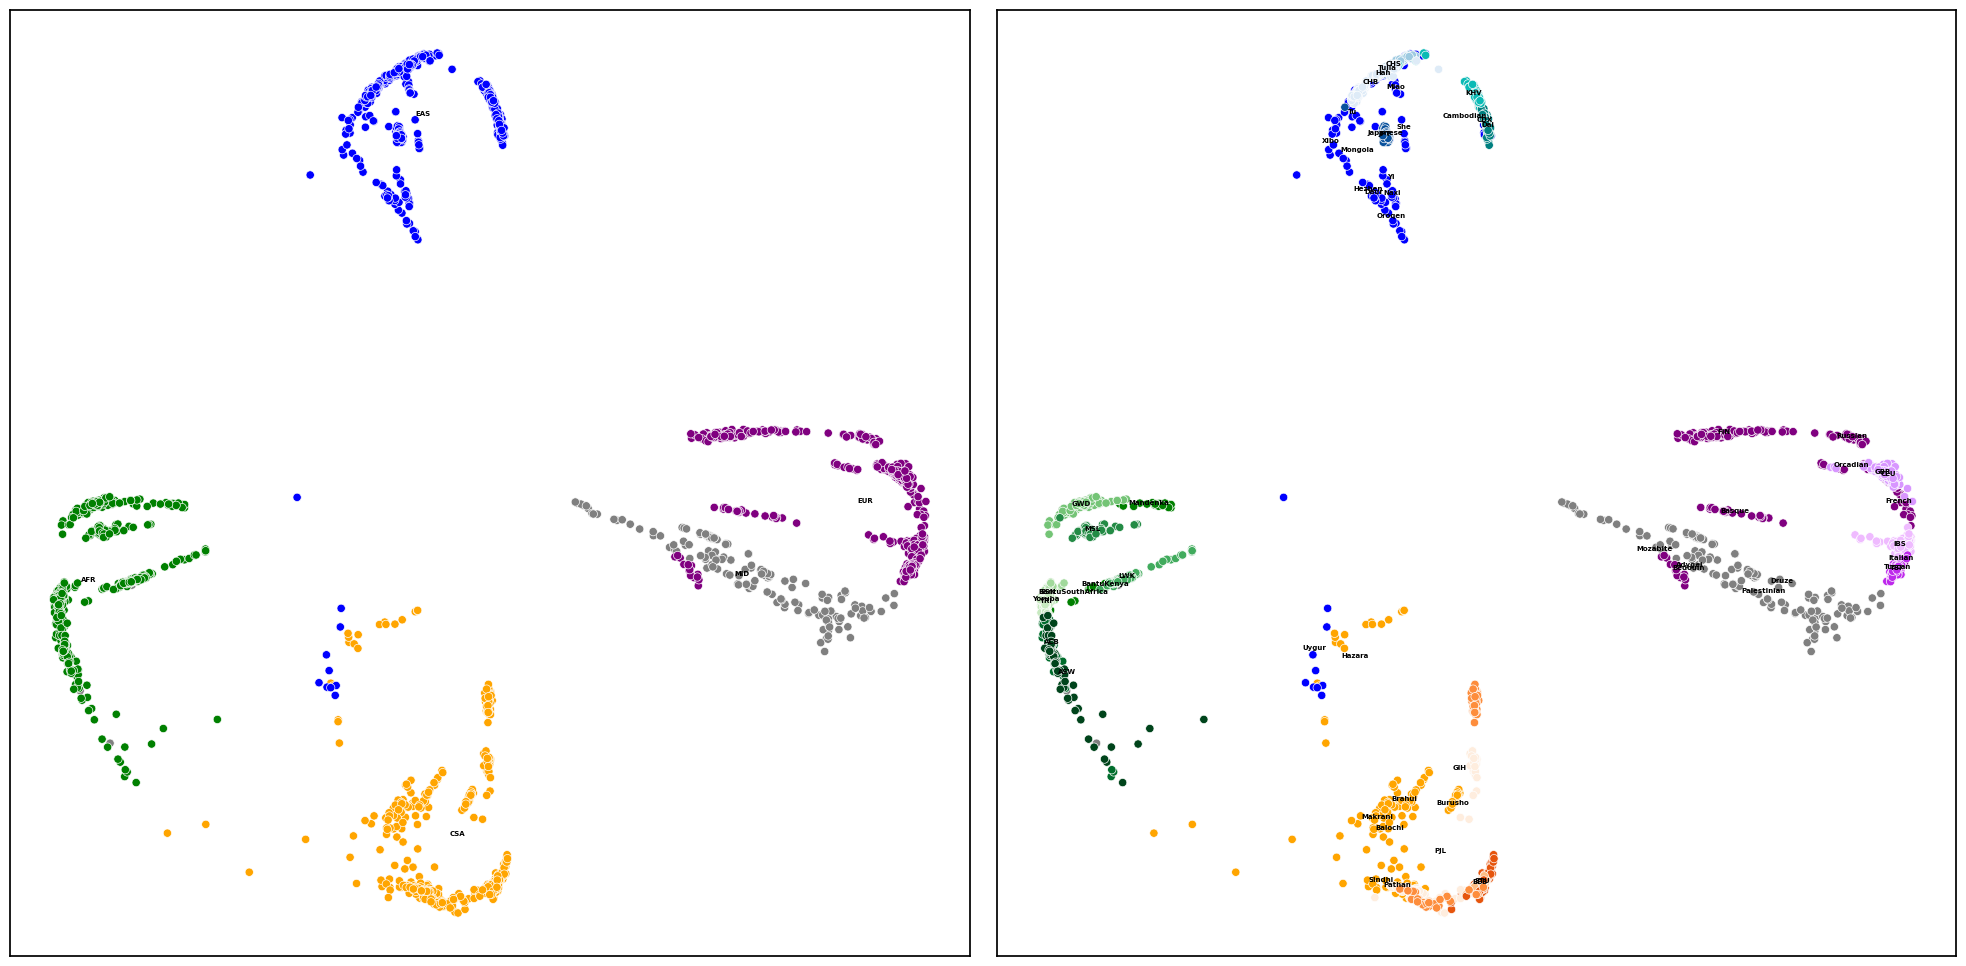

In [21]:
fig, ax = plt.subplots(ncols=2, figsize=(20,10))

plotting.plot_embeddings(phate_emb, 
                         metadata_labels_nomiddle_noadmix['Superpopulation'].values, 
                         None,
                         pop_palette_hgdp_coarse,
                         label_order_hgdp_coarse_nomiddle_noadmix,
                         True,
                         ax[0])
plotting.plot_embeddings(phate_emb, 
                         metadata_labels_nomiddle_noadmix['Population'].values, 
                         None,
                         pop_palette_hgdp_fine,
                         label_order_hgdp_fine_nomiddle_noadmix,
                         True,
                         ax[1])
plt.tight_layout()

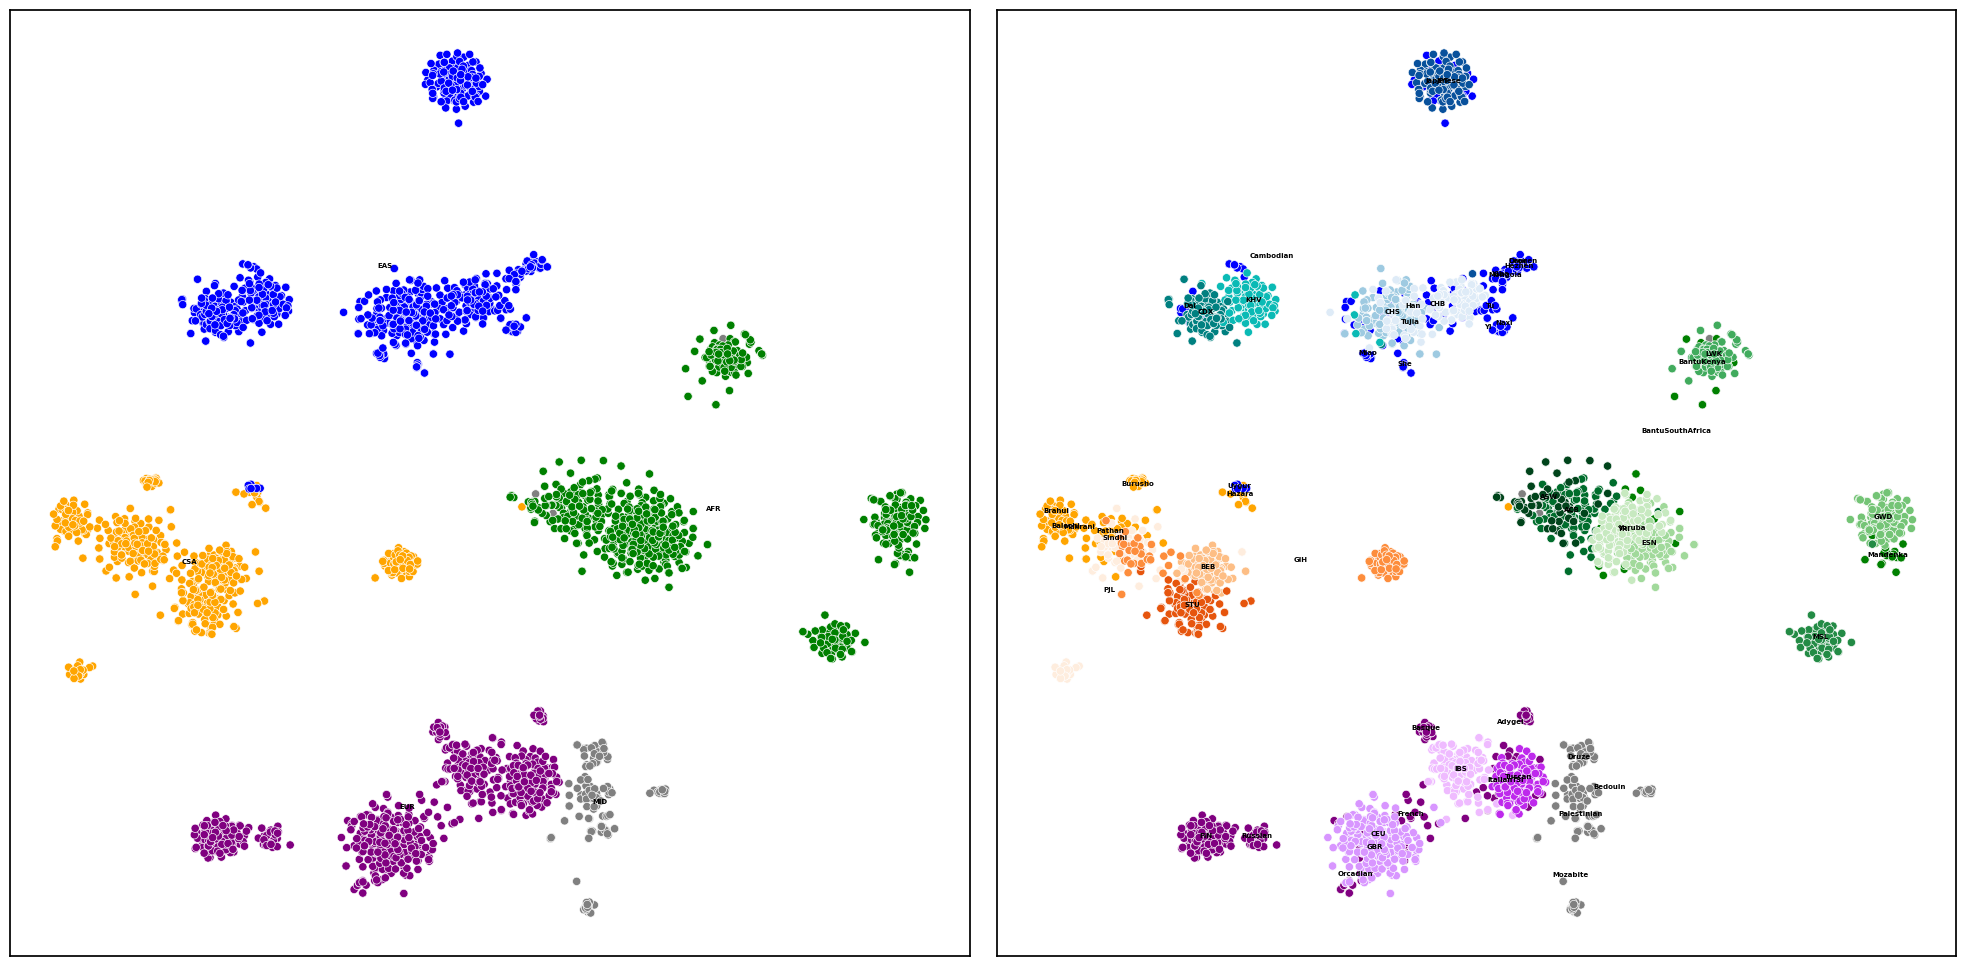

In [22]:
fig, ax = plt.subplots(ncols=2, figsize=(20,10))

plotting.plot_embeddings(tsne_emb, 
                         metadata_labels_nomiddle_noadmix['Superpopulation'].values, 
                         None,
                         pop_palette_hgdp_coarse,
                         label_order_hgdp_coarse_nomiddle_noadmix,
                         True,
                         ax[0])
plotting.plot_embeddings(tsne_emb, 
                         metadata_labels_nomiddle_noadmix['Population'].values, 
                         None,
                         pop_palette_hgdp_fine,
                         label_order_hgdp_fine_nomiddle_noadmix,
                         True,
                         ax[1])
plt.tight_layout()

Look at seperated points

In [ ]:
#from sklearn.cluster import DBSCAN
#dbscan_obj = DBSCAN(eps=0.001)
#dbscan_preds = dbscan_obj.fit_predict(phate_emb)